In [1]:
import matplotlib.pyplot as plt
# import scipy.stats as st
import seaborn as sns
import torch.nn as nn
import pandas as pd
import numpy as np

import itertools
import warnings
import torch

from torch.utils.data import DataLoader, TensorDataset, Dataset
from copy import deepcopy

from torch_wave_generator import RecursiveWaveGen

In [2]:
def torch_train_test_split(*tensors, split=.8):
    n_samples = tensors[0].shape[0]
    train_size = int(split * n_samples)
    test_size = n_samples - train_size
    rand_indices = torch.randperm(n_samples)
    train_indices, test_indices = torch.split(rand_indices, [train_size, test_size])
    assert train_indices.shape[0] == train_size, f'{train_indices.shape} != {train_size}'
    assert test_indices.shape[0] == n_samples - train_size, f'{test_indices.shape} != {n_samples - train_size}'

    data_tensors = list()
    for tensor in tensors:
        assert tensor.shape[0] == n_samples
        train_data = tensor[train_indices]
        test_data = tensor[test_indices]
        data_tensors.extend((train_data, test_data))
    return data_tensors
    
class TorchSiameseDataset(Dataset):
    def __init__(self, data, labels):
        assert data.shape[0] == labels.shape[0], f'Dim 0 mismatch, {data.shape} != {labels.shape}'
        self._data = data.unsqueeze(1)
        self._labels = labels
        return
    
    @property
    def shape(self):
        return self._data.shape

    def __len__(self):
        return self._data.shape[0]

    def __getitem__(self, left_index):
        size = 1 if isinstance(left_index, (int, np.int32)) else torch.max(left_index)
        right_index = torch.randperm(size).squeeze().int()
        left = self._data[left_index]
        right = self._data[right_index]

        left_label = self._labels[left_index]
        right_label = self._labels[right_index]
        label = torch.abs(left_label - right_label)
        return left, right, label
    
    def get_full(self):
        left_index = torch.linspace(0, len(self) - 1, len(self)).int()
#         right_index = torch.randint(0, len(self), len(self))
        right_index = torch.randperm(len(self)).squeeze().int()
    
        left = self._data[left_index]
        right = self._data[right_index]

        left_label = self._labels[left_index]
        right_label = self._labels[right_index]
        label = torch.abs(left_label - right_label)
        return left, right, label

In [3]:
n_samples = 100
amps = [1,.5,.25,.15,.05,.005]
dataset_dict = {
    amp : RecursiveWaveGen(size=240).n_periods(3).cos().amp(amp).repeat(n_samples).gaussian_noise(0,.1).sample()
    for amp
    in amps
}

torch.Size([240])
torch.Size([240])
torch.Size([240])
torch.Size([240])
torch.Size([240])
torch.Size([240])


In [4]:
data, labels = zip(*[(data, torch.repeat_interleave(torch.tensor(amp).unsqueeze(0), data.shape[0], 0)) for amp, data in dataset_dict.items()])

data = torch.cat(data, 0)
labels = torch.cat(labels, 0)

train_data, test_data, train_labels, test_labels = torch_train_test_split(data, labels, split=.8)

train_dataset = TorchSiameseDataset(train_data, train_labels)
test_dataset = TorchSiameseDataset(test_data, test_labels)

In [5]:
class SineSiamese(nn.Module):
    def __init__(
        self, 
        input_size, 
        out_channels=16, 
        kernel_size=2, 
        stride=4, 
        pool_kernel=4, 
#         drop=.4, 
        alpha=.2,
    ):
        super(SineSiamese, self).__init__()
        conv1_shape = (input_size - kernel_size) // stride + 1
        pool_shape = (conv1_shape - pool_kernel) // pool_kernel + 1
        
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=out_channels, kernel_size=kernel_size, stride=stride),
            nn.LeakyReLU(negative_slope=alpha),
            nn.MaxPool1d(kernel_size=pool_kernel),            
            nn.Linear(pool_shape, 1),
        )    
        return
        
    def forward(self, x1, x2):
        x1 = self.encoder(x1)
        x2 = self.encoder(x2)
        return x1, x2
    
    def loss(self, x1, x2, label, margin=0):
        euclidean_distance = nn.functional.pairwise_distance(x1, x2)
        contrast = torch.clamp(margin - euclidean_distance, min=0.0)
        contrastive_loss = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) + label * torch.pow(contrast, 2))
        return contrastive_loss

In [6]:
def train(
    model, 
    train_dataset, 
    test_dataset, 
    n_epochs=1000,
    batch_size=64,
    criterion=torch.nn.MSELoss(),
    optimizer=torch.optim.RMSprop,
    early_stop_patience=0,
    test_full=True,
    print_=False,
):
    optimizer = optimizer(model.parameters())
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    if early_stop_patience:
        patience = 0
        model_buffer = None
        loss_buffer = torch.tensor(float('inf'))

    items = list()
    for epoch in range(n_epochs):
        p = print_ & True
        for (train_left, train_right, train_label), (test_left, test_right, test_label) in zip(train_dataloader, test_dataloader):
            optimizer.zero_grad()
            train_left_output, train_right_output = model(train_left, train_right)
            train_loss = model.loss(train_left_output, train_right_output, train_label)       
            train_loss.backward()
            optimizer.step()

            with torch.no_grad():
                test_left_output, test_right_output = model(test_left, test_right)
                test_loss = model.loss(test_left_output, test_right_output, test_label)

                if p and not epoch % 10:
                    print('Train Loss', train_loss.item())
                    print('Test Loss', test_loss.item())
                    p = False
                
        if test_full:
            train_left, train_right, train_label = train_dataset.get_full()
            test_left, test_right, test_label = test_dataset.get_full()
            
            train_left_output, train_right_output = model(train_left, train_right)
            train_loss = model.loss(train_left_output, train_right_output, train_label)  
            
            test_left_output, test_right_output = model(test_left, test_right)
            test_loss = model.loss(test_left_output, test_right_output, test_label)
            if early_stop_patience:
                if test_loss > loss_buffer:
                    patience += 1
                    if patience >= early_stop_patience:
                        items = items[:-early_stop_patience]
                        model = model_buffer
                        break
                else:
                    model_buffer = model
                    loss_buffer = test_loss
        elif early_stop_patience:
            warnings.warn('Early Stopping Patience argument unused, full data evaluation at end of epochs is disabled. \n Set test_full to True for early stopping.')
        
        items.append((train_loss.item(), test_loss.item()))
    return model, items

def plot_loss(items, title='', step=1):
    plt.figure(figsize=(16,8))
    train_loss, test_loss = zip(*items)
    colors = sns.color_palette('Spectral', 8)
    sns.lineplot(train_loss[::step], dashes=False, color=colors[0], label='Train MSE')
    sns.lineplot(test_loss[::step], dashes=False, color=colors[3], label='Test MSE')
    if title:
        plt.title(title)
    plt.legend()
    plt.show()
    return

In [7]:
out_channelss = [1,2,4]
kernel_sizes = [4,8,6,32]
strides = [4,16,32,64,128]
pool_kernels = [16,32,128,192,256]

total_i = np.prod((len(out_channelss), len(kernel_sizes), len(strides), len(pool_kernels)))

columns = ['out_channels','kernel_size','stride','pool_kernel','train_loss','test_loss']
rows = list()
n_epochs = 30
batch_size = 128
for i, (out_channels, kernel_size, stride, pool_kernel) in enumerate(itertools.product(out_channelss, kernel_sizes, strides, pool_kernels)):
    if stride is None:
        stride = kernel_size
    if stride > kernel_size or stride > pool_kernel:
        continue
        
    print('Input Set', i + 1, 'out of', total_i, end='\n')
    print(out_channels, kernel_size, stride, pool_kernel, sep='|')
    
    model = SineSiamese(
        train_dataset.shape[2] - 1,
        out_channels=out_channels,
        kernel_size=kernel_size,
        stride=stride,
        pool_kernel=pool_kernel,
    ).float()
    
    try:
        model, items = train(
            model, 
            train_dataset, 
            test_dataset, 
            n_epochs=n_epochs, 
            batch_size=batch_size, 
            test_full=True,
            early_stop_patience=5,
        )
    except RuntimeError as re:
        warnings.warn(str(re))
        continue
        
    if not len(items):
        print('Missing loss')
        continue
    train_loss, test_loss = zip(*items)
    train_loss = np.mean(train_loss[2:])
    test_loss = np.mean(test_loss[2:])
    
    rows.append((out_channels, kernel_size, stride, pool_kernel, train_loss, test_loss))

Input Set 1 out of 300
1|4|4|16
Input Set 2 out of 300
1|4|4|32
Input Set 3 out of 300
1|4|4|128


C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
C:\Users\Nick\AppData\Local\Temp\ipykernel_31368\1519616116.py:40: UserWarning: Given input size: (1x1x60). Calculated output size: (1x1x0). Output size is too small
  warnings.warn(str(re))


Input Set 4 out of 300
1|4|4|192
Input Set 5 out of 300
1|4|4|256
Input Set 26 out of 300
1|8|4|16
Input Set 27 out of 300
1|8|4|32
Input Set 28 out of 300
1|8|4|128
Input Set 29 out of 300
1|8|4|192
Input Set 30 out of 300
1|8|4|256
Input Set 51 out of 300
1|6|4|16


C:\Users\Nick\AppData\Local\Temp\ipykernel_31368\1519616116.py:40: UserWarning: Given input size: (1x1x59). Calculated output size: (1x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Input Set 52 out of 300
1|6|4|32
Input Set 53 out of 300
1|6|4|128
Input Set 54 out of 300
1|6|4|192
Input Set 55 out of 300
1|6|4|256
Input Set 76 out of 300
1|32|4|16
Input Set 77 out of 300
1|32|4|32
Input Set 78 out of 300
1|32|4|128
Input Set 79 out of 300
1|32|4|192
Input Set 80 out of 300
1|32|4|256
Input Set 81 out of 300
1|32|16|16
Input Set 82 out of 300
1|32|16|32
Input Set 83 out of 300
1|32|16|128
Input Set 84 out of 300
1|32|16|192
Input Set 85 out of 300
1|32|16|256
Input Set 87 out of 300
1|32|32|32
Input Set 88 out of 300
1|32|32|128
Input Set 89 out of 300
1|32|32|192
Input Set 90 out of 300
1|32|32|256
Input Set 101 out of 300
2|4|4|16
Input Set 102 out of 300
2|4|4|32
Input Set 103 out of 300
2|4|4|128


C:\Users\Nick\AppData\Local\Temp\ipykernel_31368\1519616116.py:40: UserWarning: Given input size: (1x1x53). Calculated output size: (1x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_31368\1519616116.py:40: UserWarning: Given input size: (1x1x14). Calculated output size: (1x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_31368\1519616116.py:40: UserWarning: Given input size: (1x1x7). Calculated output size: (1x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_31368\1519616116.py:40: UserWarning: The size of tensor a (128) must match the size of tensor b (2) at non-singleton dimension 1
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_31368\1519616116.py:40: UserWarning: Given input size: (2x1x60). Calculated output size: (2x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykern

Input Set 104 out of 300
2|4|4|192
Input Set 105 out of 300
2|4|4|256
Input Set 126 out of 300
2|8|4|16
Input Set 127 out of 300
2|8|4|32
Input Set 128 out of 300
2|8|4|128
Input Set 129 out of 300
2|8|4|192
Input Set 130 out of 300
2|8|4|256
Input Set 151 out of 300
2|6|4|16
Input Set 152 out of 300
2|6|4|32
Input Set 153 out of 300
2|6|4|128
Input Set 154 out of 300
2|6|4|192
Input Set 155 out of 300
2|6|4|256
Input Set 176 out of 300
2|32|4|16
Input Set 177 out of 300
2|32|4|32
Input Set 178 out of 300
2|32|4|128
Input Set 179 out of 300
2|32|4|192
Input Set 180 out of 300
2|32|4|256
Input Set 181 out of 300
2|32|16|16
Input Set 182 out of 300
2|32|16|32
Input Set 183 out of 300
2|32|16|128
Input Set 184 out of 300
2|32|16|192
Input Set 185 out of 300
2|32|16|256
Input Set 187 out of 300
2|32|32|32
Input Set 188 out of 300
2|32|32|128
Input Set 189 out of 300
2|32|32|192
Input Set 190 out of 300
2|32|32|256
Input Set 201 out of 300
4|4|4|16
Input Set 202 out of 300
4|4|4|32
Input Se

C:\Users\Nick\AppData\Local\Temp\ipykernel_31368\1519616116.py:40: UserWarning: Given input size: (2x1x14). Calculated output size: (2x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_31368\1519616116.py:40: UserWarning: Given input size: (2x1x7). Calculated output size: (2x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_31368\1519616116.py:40: UserWarning: The size of tensor a (128) must match the size of tensor b (4) at non-singleton dimension 1
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_31368\1519616116.py:40: UserWarning: Given input size: (4x1x60). Calculated output size: (4x1x0). Output size is too small
  warnings.warn(str(re))


Input Set 227 out of 300
4|8|4|32
Input Set 228 out of 300
4|8|4|128
Input Set 229 out of 300
4|8|4|192
Input Set 230 out of 300
4|8|4|256
Input Set 251 out of 300
4|6|4|16
Input Set 252 out of 300
4|6|4|32
Input Set 253 out of 300
4|6|4|128
Input Set 254 out of 300
4|6|4|192
Input Set 255 out of 300
4|6|4|256
Input Set 276 out of 300
4|32|4|16
Input Set 277 out of 300
4|32|4|32
Input Set 278 out of 300
4|32|4|128
Input Set 279 out of 300
4|32|4|192
Input Set 280 out of 300
4|32|4|256


C:\Users\Nick\AppData\Local\Temp\ipykernel_31368\1519616116.py:40: UserWarning: Given input size: (4x1x59). Calculated output size: (4x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_31368\1519616116.py:40: UserWarning: Given input size: (4x1x53). Calculated output size: (4x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_31368\1519616116.py:40: UserWarning: Given input size: (4x1x14). Calculated output size: (4x1x0). Output size is too small
  warnings.warn(str(re))


Input Set 281 out of 300
4|32|16|16
Input Set 282 out of 300
4|32|16|32
Input Set 283 out of 300
4|32|16|128
Input Set 284 out of 300
4|32|16|192
Input Set 285 out of 300
4|32|16|256
Input Set 287 out of 300
4|32|32|32
Input Set 288 out of 300
4|32|32|128
Input Set 289 out of 300
4|32|32|192
Input Set 290 out of 300
4|32|32|256


C:\Users\Nick\AppData\Local\Temp\ipykernel_31368\1519616116.py:40: UserWarning: Given input size: (4x1x7). Calculated output size: (4x1x0). Output size is too small
  warnings.warn(str(re))


In [8]:
grid_df = pd.DataFrame(rows)
assert grid_df.shape[1] == len(columns), f'{grid_df.shape[1]} != {len(columns)}'
grid_df.columns = columns
grid_df.to_csv(f'training_io_{pd.to_datetime("today").strftime("%Y-%m-%d:%H")}.csv')
display(grid_df)

,out_channels,kernel_size,stride,pool_kernel,train_loss,test_loss
0,1,4,4,16,1.222819e-04,1.247631e-04
1,1,4,4,32,3.320123e-10,3.413129e-10
2,1,8,4,16,1.377644e-05,1.224710e-05
3,1,8,4,32,1.508559e-03,1.635945e-03
4,1,6,4,16,NaN,NaN
5,1,6,4,32,5.766957e-05,6.002084e-05
6,1,32,4,16,3.214360e-05,3.209382e-05
7,1,32,4,32,9.361584e-03,1.025251e-02


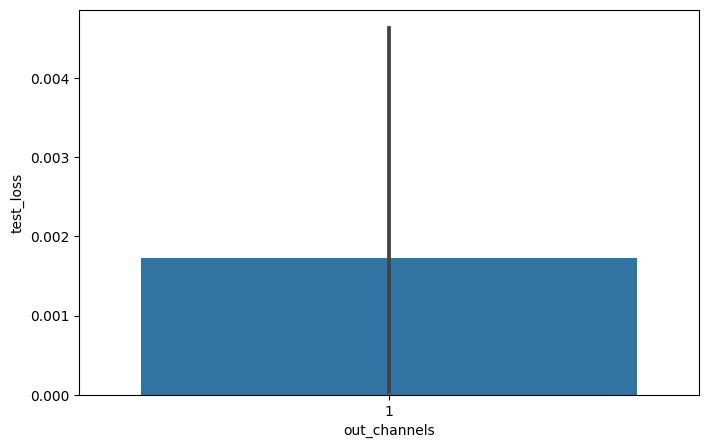

C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


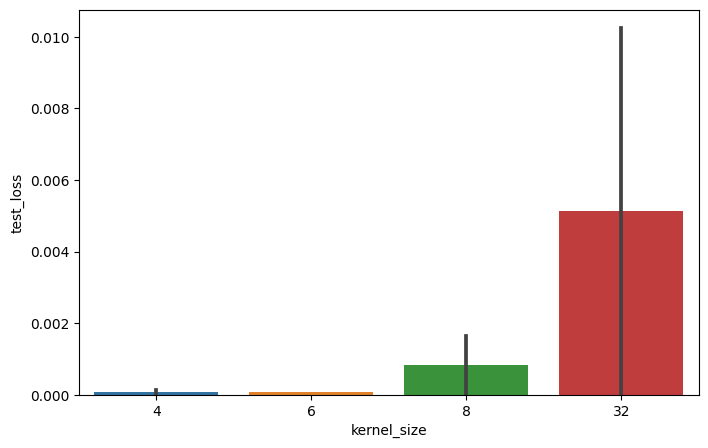

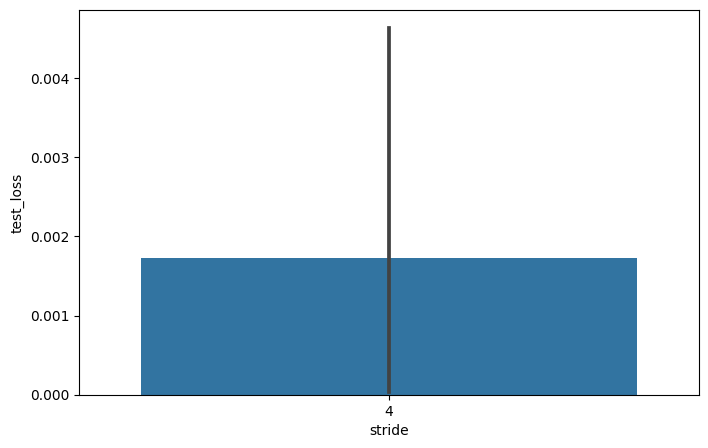

C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


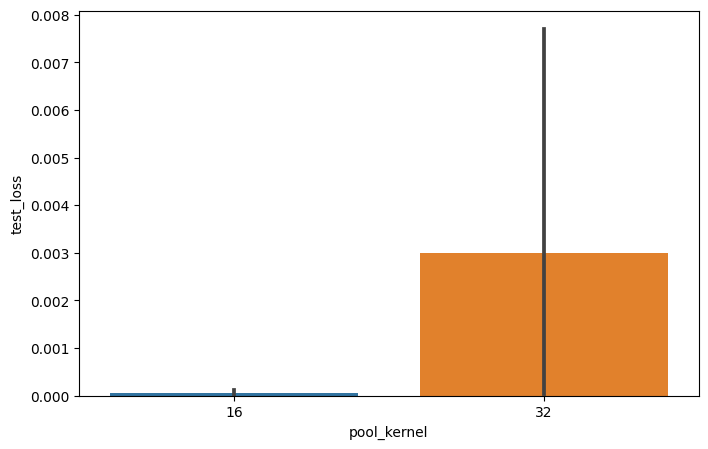

In [9]:
for col in ['out_channels','kernel_size','stride','pool_kernel']:
    plt.figure(figsize=(8,5))
    sns.barplot(data=grid_df, x=col, y='test_loss')
    plt.show()

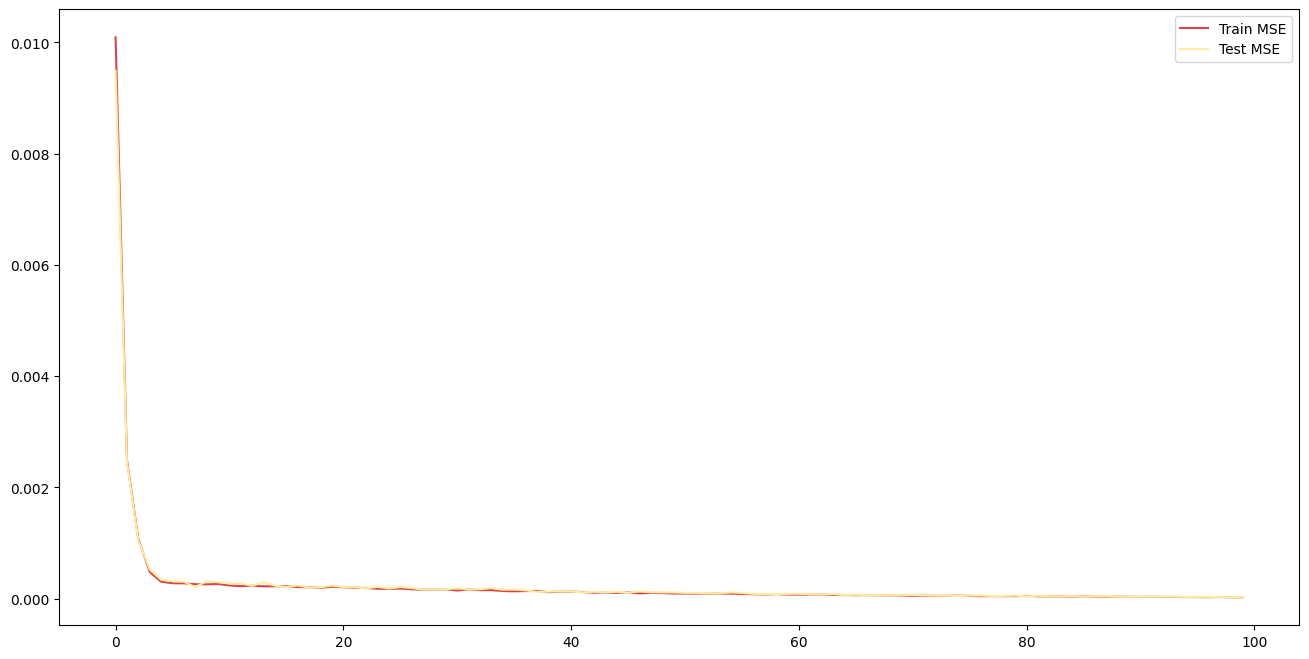

In [10]:
best_out_channels, best_kernel_size, best_stride, best_pool_kernel = grid_df.iloc[grid_df['test_loss'].argmin(),:4].to_numpy(dtype=np.int32)

# display(best_out_channels, best_kernel_size, best_stride, best_pool_kernel)
model = SineSiamese(
    train_dataset.shape[2] - 1,
    out_channels=best_out_channels,
    kernel_size=best_kernel_size,
    stride=best_stride,
    pool_kernel=best_pool_kernel,
).float()

model, items = train(
    model, 
    train_dataset, 
    test_dataset, 
    n_epochs=100, 
    test_full=True, 
    early_stop_patience=None,
) 
plot_loss(
    items,
    title=''
)
torch.save(model, 'best_siamese_model.pt')

tensor([[0.0104]], grad_fn=<SubBackward0>)


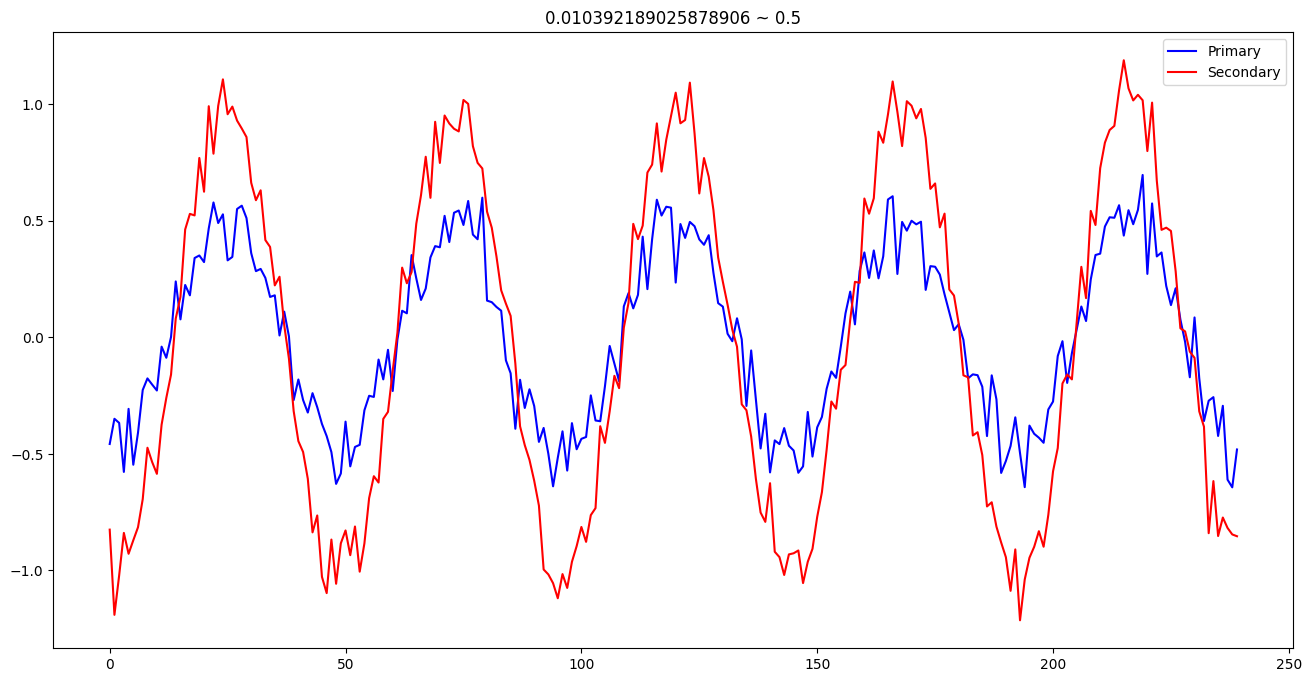

tensor([[0.0082]], grad_fn=<SubBackward0>)


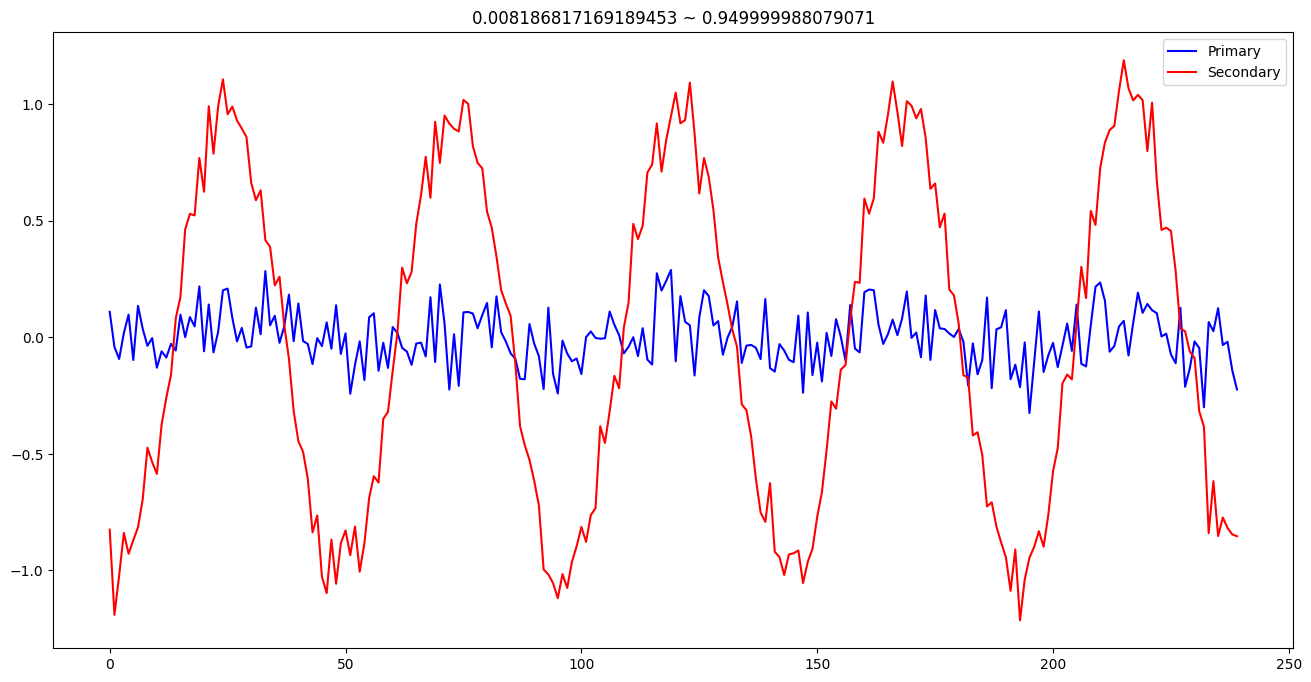

tensor([[-0.0005]], grad_fn=<SubBackward0>)


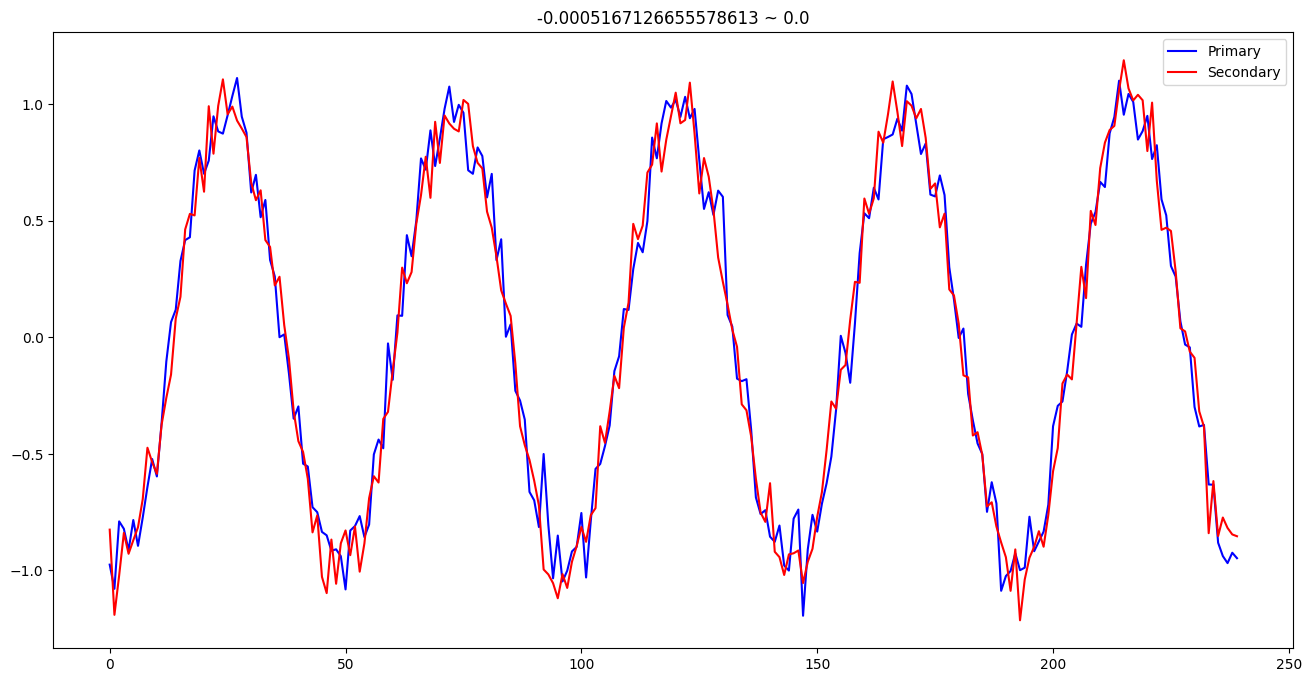

tensor([[0.0121]], grad_fn=<SubBackward0>)


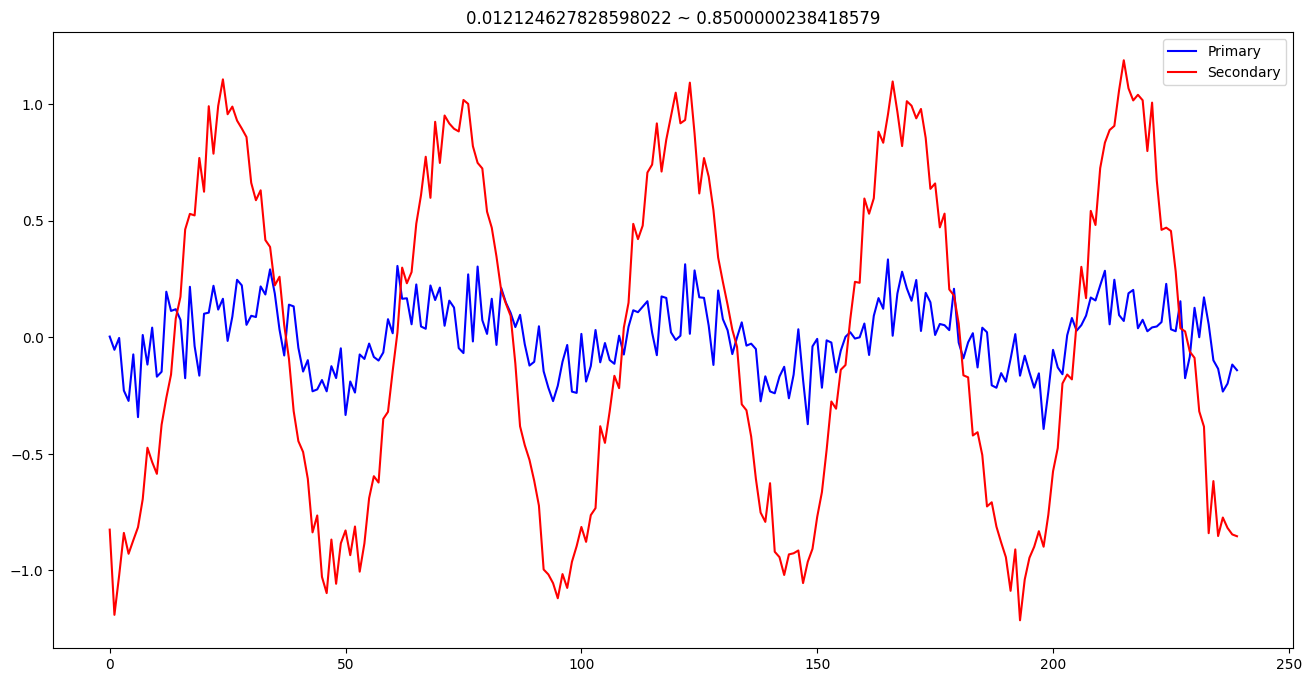

tensor([[0.0100]], grad_fn=<SubBackward0>)


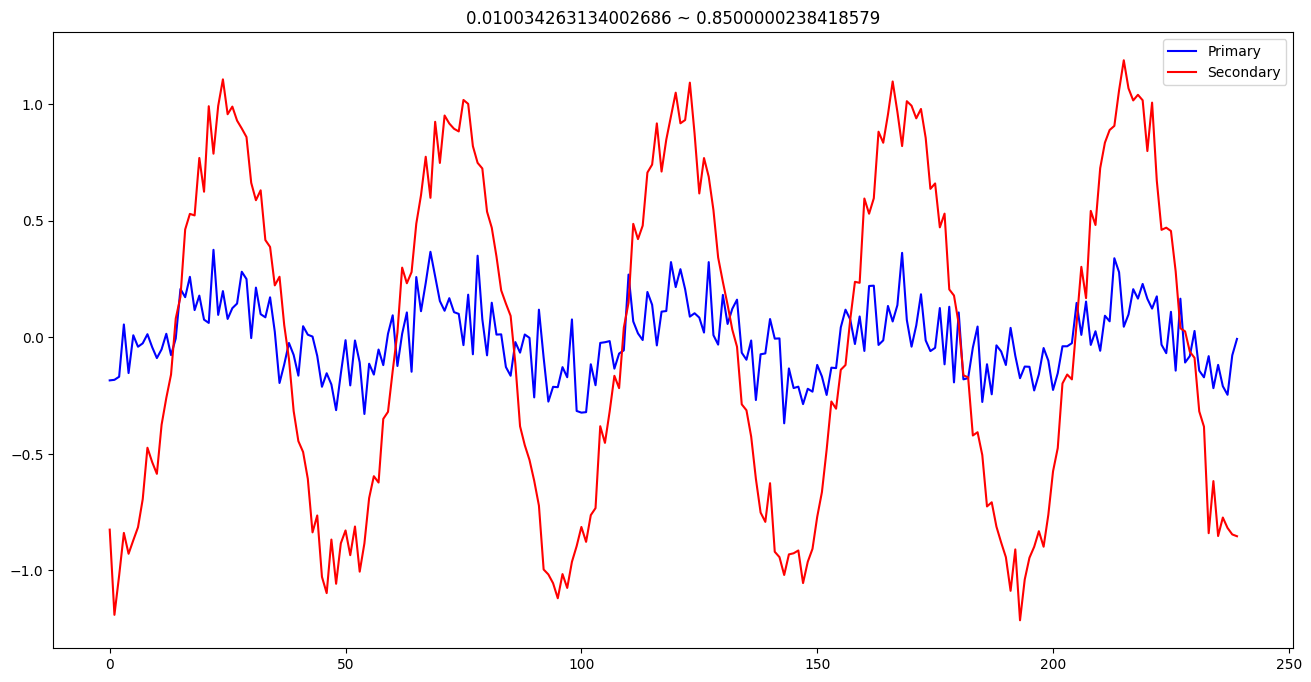

In [21]:
for i in np.random.choice(len(test_dataset), size=5):
    x1, x2, label = test_dataset[i]
    
    plt.figure(figsize=(16,8))
    plt.plot(x1.detach().numpy().squeeze(), color='blue', label='Primary')
    plt.plot(x2.detach().numpy().squeeze(), color='red', label='Secondary')

    x1, x2 = model(x1, x2)
    z = x2 -x1
    print(z)
    
    plt.title(str(z.item()) + ' ~ ' + str(label.item()))
    plt.legend()
    plt.show()